In [10]:
# Notebook to test all functions and classes to be included in the scheduling module

In [31]:
# Import necessary libraries
import ephem
import math
import seaborn
from datetime import timedelta
from itertools import islice
import matplotlib.pyplot as plt


In [18]:
class TLE:
    """TLE class used for various tle attributes.
    
    Args: a three element list containing tle lines
    """
    def __init__(self, tle):
        self.tle = tle
        self.tle0 = tle[0]
        self.tle1 = tle[1]
        self.tle2 = tle[2]
        self.name = tle[0].rstrip()
        self.noradid = tle[1][2:7]
        self.epoch = tle[1][18:32]
        self.inclination = tle[2][8:16]

    def __str__(self):
        return '%s\n%s\n%s' % (self.tle0, self.tle1, self.tle2)


In [23]:
# get_tles() function definition
def get_tles(file):
    """Returns a list of tle's from a file.

    Arguments:
    file -- file name string containing unparsed tles
    """
    data = []
    with open(file) as f:
        while True:
            #an iterator that returns the next N lines and stops
            tripleline = islice(f, 3)
            #loop over these N lines, removing trailing spaces and \n
            tle = [x.rstrip() for x in tripleline]

            #only accept complete data
            #the end of the file *should* have len(tle)==0 but
            #this also handles extra junk at the end
            if len(tle) == 3:
                data.append(tle)
            else:
                break
    return data

In [24]:
# get_passes() function definition
def new_get_passes(observer, tle, start_time, num_passes=None, duration=None):
    """Config obs and sat, Return pass data for all passes in given interval.

    Arguments:
    observer -- 4 element list containing desired [name,lat,lon,alt]
    tle -- 3 element list containing desired tle [line0,line1,line2]
    start_time -- ephem.date string formatted 'yyyy/mm/dd hr:min:sec'
    num_passes -- integer number of desired passes (defualt None)
    duration -- float number of hours or fraction of hours (default None)

    Specify either num_passes or duration.
    If both, use min(num_passes, duration).
    If neither, find passes for next 24 hours.
    """

    obs_name, obs_lat, obs_lon, obs_alt = observer
    tle_line0, tle_line1, tle_line2 = tle

    # Set up location of observer
    ground_station = ephem.Observer()
    ground_station.name = obs_name                # name string
    ground_station.lon = obs_lon                  # in degrees (+E)
    ground_station.lat = obs_lat                  # in degrees (+N)
    ground_station.elevation = obs_alt            # in meters
    ground_station.date = ephem.date(start_time)  # in UTC

    # Read in most recent satellite TLE data
    sat = ephem.readtle(tle_line0, tle_line1, tle_line2)

    contacts = []

    if duration is None and num_passes is None:
        # get passes for next 24 hrs
        duration = 24
        # set num_passes > max passes possible in duration.
        # duration is in hours, so 4 per hour is large
        # enough for duration to break out of loop.
        num_passes = 4 * int(duration)
        # set end_time longer than suggested length for tle's
        end_time = ephem.date(ground_station.date+5*365)
    if duration is not None and num_passes is None:
        # set num_passes > max passes possible in duration.
        # duration is in hours, so 4 per hour is large
        # enough for duration to break out of loop.
        num_passes = 4 * int(duration)
        end_time = ephem.date(ground_station.date+duration*ephem.hour)
    if duration is None and num_passes is not None:
        # set end_time longer than suggested length for tle's
        end_time = ephem.date(ground_station.date+5*365)
    if num_passes is not None and duration is not None:
        # if both are given, use minimum
        end_time = ephem.date(ground_station.date+duration*ephem.hour)

    try:
        for i in range(num_passes):
            if ground_station.date > end_time:
                break
            sat.compute(ground_station)  # compute all body attributes for sat
            # next pass command yields array with [0]=rise time,
            # [1]=rise azimuth, [2]=max alt time, [3]=max alt,
            # [4]=set time, [5]=set azimuth
            info = ground_station.next_pass(sat)
            rise_time, rise_az, max_alt_time, max_alt, set_time, set_az = info
            deg_per_rad = 180.0/math.pi           # use to conv azimuth to deg
            try:
                pass_duration = timedelta(days=set_time-rise_time)  # timedelta
                r_angle = (rise_az*deg_per_rad)
                s_angle = (set_az*deg_per_rad)
            except TypeError:
                # when no set or rise time
                pass
            try:
                rising = rise_time.datetime().ctime()
                setting = set_time.datetime().ctime()
                pass_seconds = timedelta.total_seconds(pass_duration)
            except AttributeError:
                # when no set or rise time
                pass

            pass_data = {
                'start': rising,
                'end': setting,
                'duration': pass_seconds,
                'rise_az': r_angle,
                'set_az': s_angle,
            }

            try:
                if set_time > rise_time:  # only update if set time > rise time
                    ground_station.date = set_time  # new obs time = prev set time
                    if ground_station.date <= end_time:
                        contacts.append(pass_data)
            except TypeError:
                pass

            # increase by 1 min and look for next pass
            ground_station.date = ground_station.date + ephem.minute
    except ValueError:
        # No (more) visible passes
        pass
    return contacts


In [33]:
# calc_access_time() function definition
def calc_access_time(start, gs, tle, days):
    """Calculates Access Time in seconds/day.

    Arguments:
    start -- string formatted 'yyyy/mm/dd HH:MM:SS'
    gs -- 4 element list containing desired [name,lat,lon,alt]
    tle -- 3 element list containing desired tle [line0,line1,line2]
    days -- num of day to calc/plot access time
    """
    time = days
    start_time = ephem.date(start)
    access_list = []
    day_list = []
    #tle = TLE(tle)

    for days in range(time):
        num_passes = None
        duration = 24.0
        gs_passes = {}

        gs_passes[tle.noradid] = new_get_passes(gs, tle.tle, start_time, num_passes=num_passes, duration=duration)

        access_time = 0
        for sat, passes in gs_passes.items():
            for obs in passes:
                access_time = access_time + obs['duration']
        access_list.append(access_time)
        day_list.append(days)
        start_time = start_time + 1
    return day_list, access_list


In [34]:
# plot_access_time() function definition
def plot_access_time(start, gs, tle, days):
    """Plots Access Time in seconds/day.

    Arguments:
    start -- string formatted 'yyyy/mm/dd HH:MM:SS'
    gs -- 4 element list containing desired [name,lat,lon,alt]
    tle -- 3 element list containing desired tle [line0,line1,line2]
    days -- num of day to calc/plot access time
    """
    tle = TLE(tle)

    day_list, access_list = calc_access_time(start, gs, tle, days)

    fig = plt.figure(1)
    fig.suptitle('%s Access time for %s GS' % (tle.name, gs[0]))

    s1 = plt.subplot(221)
    s1.plot(day_list, access_list, 'b.')
    plt.xlabel('Days from %s' % (start))
    plt.ylabel('Access time (sec/day)')

    plt.subplot(222)
    plt.plot(day_list, access_list, 'b-')
    plt.xlabel('Days from %s' % (start))

    plt.show()


In [29]:
# TEST CASES

vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
start_time = '2017/6/8 00:00:00'
num_passes = None
duration = 24.0
vu_passes = {}

data = get_tles('amateur.txt')

for tle in data:
    # use NORAD ID as key for each satellite
    # value is list of passes, where each pass is a dictionary of data
    noradID = tle[2][2:7]
    vu_passes[noradID] = new_get_passes(vu, tle, start_time, num_passes=num_passes, duration=duration)


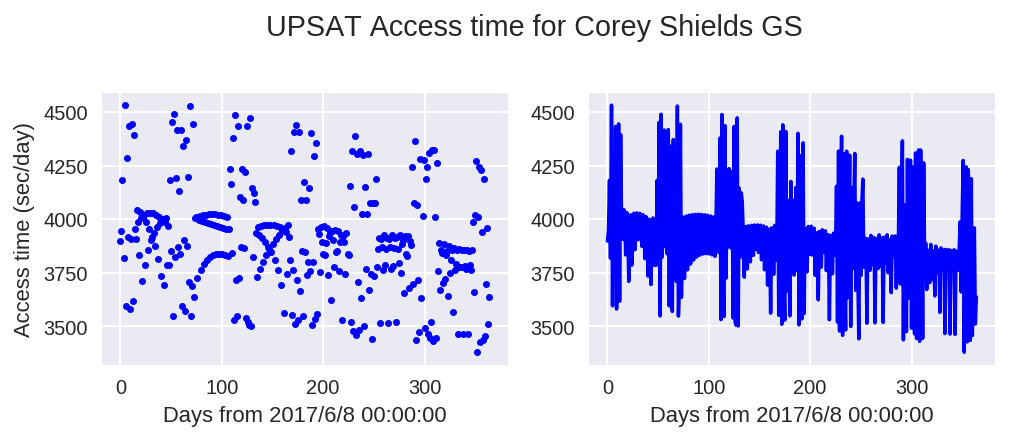

In [36]:
# TEST CASES

cs = ['Corey Shields', '39.236', '-86.305', 280]
tle = ['UPSAT                   ','1 42716U 98067LX  17166.72694047  .00011068  00000-0  16523-3 0  9996','2 42716  51.6407  45.3505 0004198 326.8454  33.2274 15.55584668  4414']
start = '2017/6/8 00:00:00'

plot_access_time(start, cs, tle, 365)